## Importing Necessary Packages

In [1]:
import os
import cv2
import numpy as np
from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt
from numpy.random import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
import torchvision.transforms.functional as TF
global device
device = torch.device('cuda' if torch.cuda.is_available() else "cpu")

## Residual Neural Network

In [2]:
class ResBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=2):
        super(ResBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size, stride, padding)
        
    def forward(self, x):
        identity = x
        x = self.conv2(self.relu(self.conv1(x)))
        x += identity
        
        return x

In [3]:
class ResNetEncoder(nn.Module):
    # layers is the list of repetations of each ResBlock
    def __init__(self, ResBlock, image_channels, layers):
        super(ResNetEncoder,self).__init__()
        
        # .... INPUT LAYER .... DWONSAMPLING
        self.encoder = nn.Sequential(nn.Conv2d(image_channels, 8, kernel_size=5, stride=2, padding=0),
        self._make_layer(ResBlock, layers[0], out_channels=8, kernel_size=5, stride=1, padding=2),
        nn.Conv2d(8, 16, kernel_size=5, stride=2, padding=2),
        self._make_layer(ResBlock, layers[1], out_channels=16, kernel_size=5, stride=1, padding=2),
        nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
        self._make_layer(ResBlock, layers[2], out_channels=32, kernel_size=3, stride=1, padding=1)
        )
        
        # .... DECODER .... TRANSPOSED CONVOLUTION FOR UPSAMPLING
        self.decoder = nn.Sequential(self._make_layer(ResBlock, layers[3], out_channels=32, kernel_size=3, stride=1, padding=1),
        nn.ConvTranspose2d(32, 16, kernel_size=2, stride=2, padding=0),
        self._make_layer(ResBlock, layers[4], out_channels=16, kernel_size=5, stride=1, padding=2),
        nn.ConvTranspose2d(16, 8, kernel_size=4, stride=2, padding=1),
        self._make_layer(ResBlock, layers[5], out_channels=8, kernel_size=5, stride=1, padding=2),
        nn.ConvTranspose2d(8, 3, kernel_size=4, stride=2, padding=1),
        )
    
    def _make_layer(self, ResBlock, num_residual_blocks, out_channels, kernel_size, stride, padding):
        in_channels = out_channels
        layers = []
        layers.append(ResBlock(in_channels, out_channels, kernel_size, stride, padding))
        
        # the output of 'block' will be fedback to itself for "num_residual_blocks-1" times
        for i in range(num_residual_blocks-1):
            layers.append(ResBlock(in_channels, out_channels, kernel_size, stride=1, padding=padding))
            
        return nn.Sequential(*layers)

    def forward(self,x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

## Discriminator

In [4]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            nn.Conv2d(32, 32, kernel_size=5, padding = 2), nn.BatchNorm2d(32), nn.LeakyReLU(0.2),
            nn.Conv2d(32, 32, kernel_size=5, stride=2, padding=2), nn.BatchNorm2d(32), nn.LeakyReLU(0.2),
            nn.Conv2d(32, 16, kernel_size=5, padding=2), nn.BatchNorm2d(16), nn.LeakyReLU(0.2),
            nn.Conv2d(16, 16, kernel_size=5, stride=2, padding=2), nn.BatchNorm2d(16), nn.LeakyReLU(0.2),
            nn.Conv2d(16, 8, kernel_size=5, padding=2), nn.BatchNorm2d(8), nn.LeakyReLU(0.2),
            nn.Conv2d(8, 8, kernel_size=3, stride=2, padding=0), nn.BatchNorm2d(8), nn.LeakyReLU(0.2),
            nn.Conv2d(8, 1, kernel_size=3, padding=1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        return self.disc(x).flatten()

## Generator with Resblocks

In [5]:
class ResnetGenerator(nn.Module):
    def __init__(self, image_channels, layers):
        super(ResnetGenerator, self).__init__()
        self.net = nn.Sequential(
            nn.Conv2d(image_channels, 8, kernel_size=5, stride=2, padding=0), nn.BatchNorm2d(8), nn.LeakyReLU(),
            self._make_layer(ResBlock, layers[0], out_channels=8, kernel_size=5, stride=1, padding=2),
            nn.Conv2d(8, 16, kernel_size=5, stride=2, padding=2), nn.BatchNorm2d(16), nn.LeakyReLU(),
            self._make_layer(ResBlock, layers[1], out_channels=16, kernel_size=5, stride=1, padding=2),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1), nn.BatchNorm2d(32), nn.LeakyReLU(),
            self._make_layer(ResBlock, layers[2], out_channels=32, kernel_size=5, stride=1, padding=2),
            nn.Conv2d(32, 128, kernel_size=3, stride=2, padding=1), nn.BatchNorm2d(128), nn.LeakyReLU(),
            self._make_layer(ResBlock, layers[3], out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.ConvTranspose2d(128, 32, kernel_size=3, stride=2, padding=0)
        )
        
    def _make_layer(self, ResBlock, num_residual_blocks, out_channels, kernel_size, stride, padding):
        in_channels = out_channels
        layers = []
        layers.append(ResBlock(in_channels, out_channels, kernel_size, stride, padding))
        
        # the output of 'block' will be fedback to itself for "num_residual_blocks-1" times
        for i in range(num_residual_blocks-1):
            layers.append(ResBlock(in_channels, out_channels, kernel_size, stride=1, padding=padding))
            
        return nn.Sequential(*layers)
        
    def forward(self, x):
        x = self.net(x)
        return F.interpolate(x, size=16)

In [6]:
def gradient_penalty(critic, real_sample, fake_sample,
                     device = torch.device("cuda" if torch.cuda.is_available() else "cpu")):
    
    #BATCH_SIZE, C, H, W = real_sample.shape
    #alpha = torch.randn((BATCH_SISE, 1, 1, 1)).repeat(1, C, H, W).to(device)
    alpha = torch.rand(1, 1)
    alpha = alpha.expand(real_sample.size()).to(device)
    interpolates = alpha * real_sample + (1- alpha) * fake_sample
    
    # Calculate the critic score
    interpolates = Variable(interpolates, requires_grad=True)
    mixed_scores = critic(interpolates)
    
    # Take the gradient of the scores with respect to the feature_maps
    gradient = torch.autograd.grad(
        inputs = interpolates,
        outputs = mixed_scores,
        grad_outputs = torch.ones_like(mixed_scores).to(device),
        create_graph = True, retain_graph = True, only_inputs=True
    )[0]
    
    gradient_penalty = ((gradient.norm(2, dim=1) - 1) ** 2).mean()
    return gradient_penalty

## Weight Initialisation and smooth labelling for a stable GAN training

In [1]:
def initialize_weights(model):
    for m in model.modules():
        if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
            nn.init.normal_(m.weight.data, 0.0, 0.02)

def smooth_positive_labels(y):
    y =  torch.ones(y.size(0), device=device)
    return y - 0.3 + (torch.rand(y.size(0), device=device) * 0.5)

def smooth_negative_labels(y):
    y = torch.zeros(y.size(0), device=device)
    return y + torch.rand(y.size(0), device=device) * 0.3

## Transform image to torch.tensor and cropping (128x128)

In [ ]:
def image_loader(image_name, loader = transforms.Compose([transforms.RandomCrop(128), transforms.ToTensor(),]),
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")):
    
    image = Image.open(image_name)
    image = loader(image).unsqueeze(0)  # fake batch dimension required to fit network's input dimensions
    return image.to(device, torch.float)

## Creating Custom Dataset

In [8]:
class CustomDataset:
    def __init__(self, data_root = 'PASCAL VOC 2012 Kaggle', sharp_img_folder = 'sharp',
                 blur_img_folder = 'blurred', crop_size = (128, 128)):
        
        self.get_transforms = transforms.Compose([transforms.ToTensor(),])
        self.sharp_img_path = os.path.join(data_root, sharp_img_folder)
        self.blur_img_path = os.path.join(data_root, blur_img_folder)
        self.sharp_img_samples, self.blur_img_samples = [], []
        
        for sharp_img, blur_img in zip(os.listdir(self.sharp_img_path),
                                       os.listdir(self.blur_img_path)):
            
            sharp_img = Image.open(os.path.join(self.sharp_img_path, sharp_img))
            blur_img = Image.open(os.path.join(self.blur_img_path, blur_img))
            crop_dims =  transforms.RandomCrop.get_params(sharp_img, output_size=crop_size)
            sharp_img = self.crop_and_transform(sharp_img, crop_dims)
            blur_img = self.crop_and_transform(blur_img, crop_dims)
            #blur_img = self.addGaussianNoise(blur_img, mean=0, std=0.1, prob=0.3)
            self.sharp_img_samples.append(sharp_img)
            self.blur_img_samples.append(blur_img)
    
    def crop_and_transform(self, img, crop_dims):
        image = TF.crop(img, *crop_dims)
        image = self.get_transforms(image)      # transform it into a torch tensor
        return image
    
    def addGaussianNoise(self, img, mean, std, prob):
        noise = img.new(img.size()).normal_(mean, std)
        likelihood = torch.distributions.binomial.Binomial(1, torch.tensor([prob]))
        return img + (noise * likelihood.sample())
    
    def LoadAllDatasets(self, batch_size):
        all_datasets = list(zip(self.sharp_img_samples, self.blur_img_samples))
        return DataLoader(all_datasets, batch_size, shuffle=True, num_workers=3, pin_memory=True)

## GAN Training

In [9]:
dataset = CustomDataset()
train_loader = dataset.LoadAllDatasets(batch_size = 16)

In [19]:
end_model = 'SparseAutoEncoder'
BCE_Loss = nn.BCELoss()                            # Cross Entropy Loss
L1_Loss = nn.L1Loss()                              # L1 Loss
L2_Loss = nn.MSELoss()                             # L2 Loss

In [42]:
EnD_Module = torch.load(end_model)
Disc_Module = Discriminator().to(device)
Gen_Module = ResnetGenerator(image_channels = 3, layers = [2, 2, 2, 2]).to(device)
Disc_optimizer = optim.Adam(Disc_Module.parameters(), lr=0.0002, betas=(0.5, 0.999))
Gen_optimizer = optim.Adam(Gen_Module.parameters(), lr=0.0002, betas=(0.5, 0.999))
reg_param = 0.01
num_epochs = 50000

initialize_weights(Disc_Module)
initialize_weights(Gen_Module)
Disc_Module.train()
Gen_Module.train()
lossD_history, lossG_history = [], []

for epoch in tqdm(range(num_epochs)):
    current_DLoss = []
    current_GLoss = []
    if epoch >= 40000: reg_param = 0.001
    for I, B in train_loader:
        I = I.to(device)
        B = B.to(device)
        
        # !!!! Trainging Discriminator !!!!
        true_sample = EnD_Module.encoder(I).detach()
        fake_sample = Gen_Module(B).detach()
        
        # !!!! Smooth Labeling to improve GAN Stability !!!!
        true_label = smooth_positive_labels(I)
        fake_label = smooth_negative_labels(B)
        
        true_pred = Disc_Module(true_sample)
        true_score = true_pred.data.mean()
        fake_pred = Disc_Module(fake_sample)
        fake_score = fake_pred.data.mean()
        
        true_loss = F.binary_cross_entropy(true_pred, true_label)
        fake_loss = F.binary_cross_entropy(fake_pred, fake_label)
        Disc_loss = reg_param*(true_loss + fake_loss)
        current_DLoss.append(Disc_loss.data.mean())
        
        Disc_optimizer.zero_grad()
        Disc_loss.backward()
        Disc_optimizer.step()
        
        # !!!! Training Generator (Any Latent Vectors aren't used) !!!!
        fake_sample = Gen_Module(B)
        fake_label = smooth_positive_labels(B)
        fake_pred = Disc_Module(fake_sample)
        
        Adv_loss = F.binary_cross_entropy(fake_pred, fake_label)
        Abs_loss = L1_Loss(fake_sample, true_sample)
        Gen_loss = reg_param * Adv_loss + Abs_loss
        
        # Finetunning Generator output with MSE loss
        if reg_param == 0.001:
            Mse_loss = L2_Loss(EnD_Module.decoder(fake_sample),
                           EnD_Module.decoder(true_sample))
            Gen_loss += Mse_loss
            
        current_GLoss.append(Gen_loss.data.mean())
        Gen_optimizer.zero_grad()
        Gen_loss.backward()
        Gen_optimizer.step()
        
        # !!!! Flushing Cuda Memory !!!!
        torch.cuda.empty_cache()
    
    epoch_loss = (sum(current_DLoss)/len(current_DLoss), sum(current_GLoss)/len(current_GLoss))
    lossD_history.append(epoch_loss[0])
    lossG_history.append(epoch_loss[1])
    print(f'Epoch - {epoch} and Discriminator Loss - {epoch_loss[0]:.4f}, Generator Loss - {epoch_loss[1]:.4f}, \
    True_score - {true_score:.4f}, Fake score - {fake_score:.4f}')

  1%|          | 1/150 [00:27<1:07:47, 27.30s/it]

Epoch - 0 and Discriminator Loss - 0.0140, Generator Loss - 0.2165,     True_score - 0.4792, Fake score - 0.4792


  1%|▏         | 2/150 [00:59<1:11:19, 28.92s/it]

Epoch - 1 and Discriminator Loss - 0.0139, Generator Loss - 0.1516,     True_score - 0.4845, Fake score - 0.4836


  2%|▏         | 3/150 [01:32<1:13:31, 30.01s/it]

Epoch - 2 and Discriminator Loss - 0.0139, Generator Loss - 0.1406,     True_score - 0.4900, Fake score - 0.4876


  3%|▎         | 4/150 [02:05<1:14:53, 30.78s/it]

Epoch - 3 and Discriminator Loss - 0.0138, Generator Loss - 0.1337,     True_score - 0.4956, Fake score - 0.4912


  3%|▎         | 5/150 [02:38<1:16:05, 31.49s/it]

Epoch - 4 and Discriminator Loss - 0.0138, Generator Loss - 0.1280,     True_score - 0.5025, Fake score - 0.4949


  4%|▍         | 6/150 [03:10<1:16:25, 31.84s/it]

Epoch - 5 and Discriminator Loss - 0.0137, Generator Loss - 0.1261,     True_score - 0.5093, Fake score - 0.4975


  5%|▍         | 7/150 [03:43<1:16:26, 32.08s/it]

Epoch - 6 and Discriminator Loss - 0.0137, Generator Loss - 0.1218,     True_score - 0.5154, Fake score - 0.5146


  5%|▌         | 8/150 [04:15<1:16:08, 32.17s/it]

Epoch - 7 and Discriminator Loss - 0.0136, Generator Loss - 0.1211,     True_score - 0.5230, Fake score - 0.5045


  6%|▌         | 9/150 [04:48<1:15:41, 32.21s/it]

Epoch - 8 and Discriminator Loss - 0.0135, Generator Loss - 0.1199,     True_score - 0.5298, Fake score - 0.5085


  7%|▋         | 10/150 [05:20<1:15:14, 32.25s/it]

Epoch - 9 and Discriminator Loss - 0.0137, Generator Loss - 0.1130,     True_score - 0.5351, Fake score - 0.5180


  7%|▋         | 11/150 [05:52<1:14:46, 32.27s/it]

Epoch - 10 and Discriminator Loss - 0.0137, Generator Loss - 0.1111,     True_score - 0.5376, Fake score - 0.5387


  8%|▊         | 12/150 [06:25<1:14:16, 32.29s/it]

Epoch - 11 and Discriminator Loss - 0.0137, Generator Loss - 0.1087,     True_score - 0.5276, Fake score - 0.5234


  9%|▊         | 13/150 [06:57<1:13:55, 32.37s/it]

Epoch - 12 and Discriminator Loss - 0.0136, Generator Loss - 0.1070,     True_score - 0.5470, Fake score - 0.5491


  9%|▉         | 14/150 [07:30<1:13:22, 32.37s/it]

Epoch - 13 and Discriminator Loss - 0.0135, Generator Loss - 0.1081,     True_score - 0.5408, Fake score - 0.5214


 10%|█         | 15/150 [08:02<1:12:50, 32.37s/it]

Epoch - 14 and Discriminator Loss - 0.0137, Generator Loss - 0.1064,     True_score - 0.5522, Fake score - 0.5496


 11%|█         | 16/150 [08:35<1:12:33, 32.49s/it]

Epoch - 15 and Discriminator Loss - 0.0137, Generator Loss - 0.1038,     True_score - 0.5504, Fake score - 0.5254


 11%|█▏        | 17/150 [09:07<1:11:58, 32.47s/it]

Epoch - 16 and Discriminator Loss - 0.0132, Generator Loss - 0.1032,     True_score - 0.5557, Fake score - 0.5204


 12%|█▏        | 18/150 [09:40<1:11:29, 32.50s/it]

Epoch - 17 and Discriminator Loss - 0.0132, Generator Loss - 0.1036,     True_score - 0.5663, Fake score - 0.5420


 13%|█▎        | 19/150 [10:12<1:10:52, 32.46s/it]

Epoch - 18 and Discriminator Loss - 0.0132, Generator Loss - 0.1039,     True_score - 0.5698, Fake score - 0.5200


 13%|█▎        | 20/150 [10:45<1:10:26, 32.52s/it]

Epoch - 19 and Discriminator Loss - 0.0128, Generator Loss - 0.1038,     True_score - 0.5808, Fake score - 0.5193


 14%|█▍        | 21/150 [11:17<1:09:50, 32.48s/it]

Epoch - 20 and Discriminator Loss - 0.0128, Generator Loss - 0.1015,     True_score - 0.5927, Fake score - 0.5895


 15%|█▍        | 22/150 [11:50<1:09:18, 32.49s/it]

Epoch - 21 and Discriminator Loss - 0.0138, Generator Loss - 0.0990,     True_score - 0.5670, Fake score - 0.5670


 15%|█▌        | 23/150 [12:23<1:09:13, 32.71s/it]

Epoch - 22 and Discriminator Loss - 0.0132, Generator Loss - 0.1006,     True_score - 0.5860, Fake score - 0.5075


 16%|█▌        | 24/150 [12:55<1:08:34, 32.66s/it]

Epoch - 23 and Discriminator Loss - 0.0132, Generator Loss - 0.0979,     True_score - 0.5824, Fake score - 0.5649


 17%|█▋        | 25/150 [13:28<1:07:57, 32.62s/it]

Epoch - 24 and Discriminator Loss - 0.0136, Generator Loss - 0.0975,     True_score - 0.5658, Fake score - 0.5634


 17%|█▋        | 26/150 [14:01<1:07:24, 32.62s/it]

Epoch - 25 and Discriminator Loss - 0.0134, Generator Loss - 0.0960,     True_score - 0.5870, Fake score - 0.4990


 18%|█▊        | 27/150 [14:33<1:06:54, 32.64s/it]

Epoch - 26 and Discriminator Loss - 0.0124, Generator Loss - 0.1014,     True_score - 0.5975, Fake score - 0.4989


 19%|█▊        | 28/150 [15:08<1:07:32, 33.21s/it]

Epoch - 27 and Discriminator Loss - 0.0122, Generator Loss - 0.0988,     True_score - 0.5330, Fake score - 0.4972


 19%|█▉        | 29/150 [15:41<1:06:57, 33.20s/it]

Epoch - 28 and Discriminator Loss - 0.0128, Generator Loss - 0.0977,     True_score - 0.5252, Fake score - 0.4961


 20%|██        | 30/150 [16:14<1:05:58, 32.98s/it]

Epoch - 29 and Discriminator Loss - 0.0123, Generator Loss - 0.0953,     True_score - 0.6172, Fake score - 0.4890


 21%|██        | 31/150 [16:46<1:05:05, 32.82s/it]

Epoch - 30 and Discriminator Loss - 0.0121, Generator Loss - 0.0971,     True_score - 0.5719, Fake score - 0.4888


 21%|██▏       | 32/150 [17:18<1:04:20, 32.71s/it]

Epoch - 31 and Discriminator Loss - 0.0131, Generator Loss - 0.0957,     True_score - 0.5944, Fake score - 0.5901


 22%|██▏       | 33/150 [17:51<1:03:39, 32.65s/it]

Epoch - 32 and Discriminator Loss - 0.0127, Generator Loss - 0.0978,     True_score - 0.6161, Fake score - 0.4792


 23%|██▎       | 34/150 [18:23<1:02:59, 32.58s/it]

Epoch - 33 and Discriminator Loss - 0.0122, Generator Loss - 0.0951,     True_score - 0.6283, Fake score - 0.4718


 23%|██▎       | 35/150 [18:56<1:02:19, 32.52s/it]

Epoch - 34 and Discriminator Loss - 0.0125, Generator Loss - 0.0939,     True_score - 0.6229, Fake score - 0.4668


 24%|██▍       | 36/150 [19:28<1:01:42, 32.48s/it]

Epoch - 35 and Discriminator Loss - 0.0120, Generator Loss - 0.0955,     True_score - 0.6367, Fake score - 0.4646


 25%|██▍       | 37/150 [20:01<1:01:13, 32.51s/it]

Epoch - 36 and Discriminator Loss - 0.0114, Generator Loss - 0.0962,     True_score - 0.6417, Fake score - 0.4703


 25%|██▌       | 38/150 [20:34<1:00:51, 32.60s/it]

Epoch - 37 and Discriminator Loss - 0.0133, Generator Loss - 0.0940,     True_score - 0.5940, Fake score - 0.4593


 26%|██▌       | 39/150 [21:06<1:00:11, 32.54s/it]

Epoch - 38 and Discriminator Loss - 0.0112, Generator Loss - 0.0955,     True_score - 0.6515, Fake score - 0.4423


 27%|██▋       | 40/150 [21:38<59:30, 32.46s/it]  

Epoch - 39 and Discriminator Loss - 0.0117, Generator Loss - 0.0938,     True_score - 0.6497, Fake score - 0.4375


 27%|██▋       | 41/150 [22:10<58:53, 32.42s/it]

Epoch - 40 and Discriminator Loss - 0.0112, Generator Loss - 0.0950,     True_score - 0.6477, Fake score - 0.6480


 28%|██▊       | 42/150 [22:43<58:17, 32.39s/it]

Epoch - 41 and Discriminator Loss - 0.0113, Generator Loss - 0.0940,     True_score - 0.6671, Fake score - 0.4274


 29%|██▊       | 43/150 [23:15<57:43, 32.37s/it]

Epoch - 42 and Discriminator Loss - 0.0104, Generator Loss - 0.0938,     True_score - 0.6776, Fake score - 0.4240


 29%|██▉       | 44/150 [23:47<57:08, 32.34s/it]

Epoch - 43 and Discriminator Loss - 0.0108, Generator Loss - 0.0931,     True_score - 0.6350, Fake score - 0.6066


 30%|███       | 45/150 [24:20<56:32, 32.31s/it]

Epoch - 44 and Discriminator Loss - 0.0122, Generator Loss - 0.0931,     True_score - 0.6107, Fake score - 0.6146


 31%|███       | 46/150 [24:52<56:00, 32.31s/it]

Epoch - 45 and Discriminator Loss - 0.0138, Generator Loss - 0.0891,     True_score - 0.5822, Fake score - 0.5765


 31%|███▏      | 47/150 [25:24<55:27, 32.30s/it]

Epoch - 46 and Discriminator Loss - 0.0138, Generator Loss - 0.0922,     True_score - 0.5668, Fake score - 0.5703


 32%|███▏      | 48/150 [25:57<55:00, 32.36s/it]

Epoch - 47 and Discriminator Loss - 0.0138, Generator Loss - 0.0913,     True_score - 0.5589, Fake score - 0.5619


 33%|███▎      | 49/150 [26:29<54:24, 32.32s/it]

Epoch - 48 and Discriminator Loss - 0.0135, Generator Loss - 0.0912,     True_score - 0.5268, Fake score - 0.4684


 33%|███▎      | 50/150 [27:01<53:51, 32.32s/it]

Epoch - 49 and Discriminator Loss - 0.0131, Generator Loss - 0.0936,     True_score - 0.5955, Fake score - 0.4341


 34%|███▍      | 51/150 [27:35<53:53, 32.67s/it]

Epoch - 50 and Discriminator Loss - 0.0129, Generator Loss - 0.0919,     True_score - 0.6068, Fake score - 0.6133


 35%|███▍      | 52/150 [28:07<53:08, 32.54s/it]

Epoch - 51 and Discriminator Loss - 0.0133, Generator Loss - 0.0904,     True_score - 0.6202, Fake score - 0.6042


 35%|███▌      | 53/150 [28:39<52:28, 32.46s/it]

Epoch - 52 and Discriminator Loss - 0.0131, Generator Loss - 0.0927,     True_score - 0.6152, Fake score - 0.4190


 36%|███▌      | 54/150 [29:12<51:51, 32.41s/it]

Epoch - 53 and Discriminator Loss - 0.0129, Generator Loss - 0.0915,     True_score - 0.5243, Fake score - 0.5101


 37%|███▋      | 55/150 [29:44<51:13, 32.35s/it]

Epoch - 54 and Discriminator Loss - 0.0125, Generator Loss - 0.0890,     True_score - 0.6529, Fake score - 0.4308


 37%|███▋      | 56/150 [30:16<50:39, 32.34s/it]

Epoch - 55 and Discriminator Loss - 0.0109, Generator Loss - 0.0910,     True_score - 0.6818, Fake score - 0.4315


 38%|███▊      | 57/150 [30:48<50:07, 32.34s/it]

Epoch - 56 and Discriminator Loss - 0.0100, Generator Loss - 0.0917,     True_score - 0.6894, Fake score - 0.4052


 39%|███▊      | 58/150 [31:21<49:34, 32.33s/it]

Epoch - 57 and Discriminator Loss - 0.0106, Generator Loss - 0.0919,     True_score - 0.6888, Fake score - 0.4157


 39%|███▉      | 59/150 [31:53<48:59, 32.30s/it]

Epoch - 58 and Discriminator Loss - 0.0107, Generator Loss - 0.0929,     True_score - 0.6765, Fake score - 0.4410


 40%|████      | 60/150 [32:25<48:25, 32.29s/it]

Epoch - 59 and Discriminator Loss - 0.0095, Generator Loss - 0.0915,     True_score - 0.7236, Fake score - 0.4021


 41%|████      | 61/150 [32:58<47:53, 32.28s/it]

Epoch - 60 and Discriminator Loss - 0.0094, Generator Loss - 0.0912,     True_score - 0.7414, Fake score - 0.3785


 41%|████▏     | 62/150 [33:30<47:21, 32.29s/it]

Epoch - 61 and Discriminator Loss - 0.0105, Generator Loss - 0.0920,     True_score - 0.7189, Fake score - 0.3706


 42%|████▏     | 63/150 [34:02<46:50, 32.30s/it]

Epoch - 62 and Discriminator Loss - 0.0114, Generator Loss - 0.0880,     True_score - 0.6755, Fake score - 0.6805


 43%|████▎     | 64/150 [34:34<46:16, 32.29s/it]

Epoch - 63 and Discriminator Loss - 0.0098, Generator Loss - 0.0911,     True_score - 0.7397, Fake score - 0.3572


 43%|████▎     | 65/150 [35:07<45:44, 32.29s/it]

Epoch - 64 and Discriminator Loss - 0.0107, Generator Loss - 0.0917,     True_score - 0.6816, Fake score - 0.3623


 44%|████▍     | 66/150 [35:39<45:12, 32.29s/it]

Epoch - 65 and Discriminator Loss - 0.0134, Generator Loss - 0.0866,     True_score - 0.6443, Fake score - 0.6007


 45%|████▍     | 67/150 [36:11<44:39, 32.28s/it]

Epoch - 66 and Discriminator Loss - 0.0133, Generator Loss - 0.0911,     True_score - 0.4508, Fake score - 0.4416


 45%|████▌     | 68/150 [36:44<44:07, 32.29s/it]

Epoch - 67 and Discriminator Loss - 0.0134, Generator Loss - 0.0902,     True_score - 0.6446, Fake score - 0.4070


 46%|████▌     | 69/150 [37:16<43:36, 32.30s/it]

Epoch - 68 and Discriminator Loss - 0.0131, Generator Loss - 0.0896,     True_score - 0.7030, Fake score - 0.6910


 47%|████▋     | 70/150 [37:48<43:09, 32.37s/it]

Epoch - 69 and Discriminator Loss - 0.0137, Generator Loss - 0.0909,     True_score - 0.6365, Fake score - 0.4759


 47%|████▋     | 71/150 [38:21<42:41, 32.43s/it]

Epoch - 70 and Discriminator Loss - 0.0123, Generator Loss - 0.0891,     True_score - 0.6736, Fake score - 0.6770


 48%|████▊     | 72/150 [38:53<42:11, 32.45s/it]

Epoch - 71 and Discriminator Loss - 0.0123, Generator Loss - 0.0889,     True_score - 0.6901, Fake score - 0.6625


 49%|████▊     | 73/150 [39:26<41:40, 32.47s/it]

Epoch - 72 and Discriminator Loss - 0.0115, Generator Loss - 0.0871,     True_score - 0.4300, Fake score - 0.3265


 49%|████▉     | 74/150 [39:58<41:07, 32.47s/it]

Epoch - 73 and Discriminator Loss - 0.0131, Generator Loss - 0.0905,     True_score - 0.6506, Fake score - 0.3401


 50%|█████     | 75/150 [40:31<40:38, 32.51s/it]

Epoch - 74 and Discriminator Loss - 0.0106, Generator Loss - 0.0903,     True_score - 0.6807, Fake score - 0.4286


 51%|█████     | 76/150 [41:05<40:35, 32.91s/it]

Epoch - 75 and Discriminator Loss - 0.0134, Generator Loss - 0.0853,     True_score - 0.6179, Fake score - 0.6026


 51%|█████▏    | 77/150 [41:38<39:57, 32.85s/it]

Epoch - 76 and Discriminator Loss - 0.0132, Generator Loss - 0.0872,     True_score - 0.6288, Fake score - 0.3180


 52%|█████▏    | 78/150 [42:11<39:29, 32.91s/it]

Epoch - 77 and Discriminator Loss - 0.0092, Generator Loss - 0.0922,     True_score - 0.7136, Fake score - 0.3254


 53%|█████▎    | 79/150 [42:44<39:11, 33.13s/it]

Epoch - 78 and Discriminator Loss - 0.0088, Generator Loss - 0.0891,     True_score - 0.7485, Fake score - 0.3109


 53%|█████▎    | 80/150 [43:17<38:22, 32.90s/it]

Epoch - 79 and Discriminator Loss - 0.0085, Generator Loss - 0.0893,     True_score - 0.7675, Fake score - 0.3380


 54%|█████▍    | 81/150 [43:49<37:38, 32.73s/it]

Epoch - 80 and Discriminator Loss - 0.0085, Generator Loss - 0.0914,     True_score - 0.7623, Fake score - 0.3313


 55%|█████▍    | 82/150 [44:22<37:02, 32.68s/it]

Epoch - 81 and Discriminator Loss - 0.0083, Generator Loss - 0.0906,     True_score - 0.7786, Fake score - 0.3134


 55%|█████▌    | 83/150 [44:54<36:22, 32.57s/it]

Epoch - 82 and Discriminator Loss - 0.0082, Generator Loss - 0.0897,     True_score - 0.7708, Fake score - 0.3122


 56%|█████▌    | 84/150 [45:27<35:50, 32.59s/it]

Epoch - 83 and Discriminator Loss - 0.0088, Generator Loss - 0.0894,     True_score - 0.7880, Fake score - 0.7774


 57%|█████▋    | 85/150 [45:59<35:14, 32.53s/it]

Epoch - 84 and Discriminator Loss - 0.0128, Generator Loss - 0.0883,     True_score - 0.7066, Fake score - 0.3060


 57%|█████▋    | 86/150 [46:31<34:39, 32.49s/it]

Epoch - 85 and Discriminator Loss - 0.0112, Generator Loss - 0.0893,     True_score - 0.7000, Fake score - 0.6874


 58%|█████▊    | 87/150 [47:04<34:05, 32.46s/it]

Epoch - 86 and Discriminator Loss - 0.0137, Generator Loss - 0.0868,     True_score - 0.6426, Fake score - 0.6419


 59%|█████▊    | 88/150 [47:37<33:39, 32.57s/it]

Epoch - 87 and Discriminator Loss - 0.0139, Generator Loss - 0.0849,     True_score - 0.5553, Fake score - 0.4692


 59%|█████▉    | 89/150 [48:09<33:02, 32.49s/it]

Epoch - 88 and Discriminator Loss - 0.0138, Generator Loss - 0.0895,     True_score - 0.5033, Fake score - 0.4314


 60%|██████    | 90/150 [48:41<32:27, 32.47s/it]

Epoch - 89 and Discriminator Loss - 0.0138, Generator Loss - 0.0876,     True_score - 0.4122, Fake score - 0.4527


 61%|██████    | 91/150 [49:14<31:57, 32.51s/it]

Epoch - 90 and Discriminator Loss - 0.0135, Generator Loss - 0.0879,     True_score - 0.4004, Fake score - 0.4199


 61%|██████▏   | 92/150 [49:47<31:28, 32.57s/it]

Epoch - 91 and Discriminator Loss - 0.0130, Generator Loss - 0.0877,     True_score - 0.5830, Fake score - 0.6086


 62%|██████▏   | 93/150 [50:19<30:56, 32.58s/it]

Epoch - 92 and Discriminator Loss - 0.0137, Generator Loss - 0.0873,     True_score - 0.6754, Fake score - 0.5619


 63%|██████▎   | 94/150 [50:52<30:21, 32.53s/it]

Epoch - 93 and Discriminator Loss - 0.0136, Generator Loss - 0.0875,     True_score - 0.6440, Fake score - 0.5796


 63%|██████▎   | 95/150 [51:24<29:54, 32.62s/it]

Epoch - 94 and Discriminator Loss - 0.0130, Generator Loss - 0.0872,     True_score - 0.7102, Fake score - 0.4245


 64%|██████▍   | 96/150 [51:57<29:21, 32.63s/it]

Epoch - 95 and Discriminator Loss - 0.0126, Generator Loss - 0.0880,     True_score - 0.7039, Fake score - 0.7011


 65%|██████▍   | 97/150 [52:30<29:01, 32.86s/it]

Epoch - 96 and Discriminator Loss - 0.0137, Generator Loss - 0.0862,     True_score - 0.6529, Fake score - 0.5025


 65%|██████▌   | 98/150 [53:03<28:23, 32.76s/it]

Epoch - 97 and Discriminator Loss - 0.0136, Generator Loss - 0.0864,     True_score - 0.5329, Fake score - 0.4735


 66%|██████▌   | 99/150 [53:36<27:50, 32.75s/it]

Epoch - 98 and Discriminator Loss - 0.0133, Generator Loss - 0.0855,     True_score - 0.4725, Fake score - 0.4521


 67%|██████▋   | 100/150 [54:08<27:16, 32.73s/it]

Epoch - 99 and Discriminator Loss - 0.0122, Generator Loss - 0.0850,     True_score - 0.7024, Fake score - 0.7114


 67%|██████▋   | 101/150 [54:41<26:41, 32.69s/it]

Epoch - 100 and Discriminator Loss - 0.0136, Generator Loss - 0.0865,     True_score - 0.6574, Fake score - 0.6650


 68%|██████▊   | 102/150 [55:13<26:06, 32.63s/it]

Epoch - 101 and Discriminator Loss - 0.0135, Generator Loss - 0.0871,     True_score - 0.6333, Fake score - 0.6291


 69%|██████▊   | 103/150 [55:46<25:29, 32.54s/it]

Epoch - 102 and Discriminator Loss - 0.0137, Generator Loss - 0.0870,     True_score - 0.6391, Fake score - 0.4332


 69%|██████▉   | 104/150 [56:18<24:55, 32.50s/it]

Epoch - 103 and Discriminator Loss - 0.0137, Generator Loss - 0.0849,     True_score - 0.6450, Fake score - 0.5473


 70%|███████   | 105/150 [56:51<24:19, 32.44s/it]

Epoch - 104 and Discriminator Loss - 0.0136, Generator Loss - 0.0843,     True_score - 0.4801, Fake score - 0.4310


 71%|███████   | 106/150 [57:23<23:46, 32.41s/it]

Epoch - 105 and Discriminator Loss - 0.0134, Generator Loss - 0.0855,     True_score - 0.6223, Fake score - 0.5297


 71%|███████▏  | 107/150 [57:55<23:13, 32.40s/it]

Epoch - 106 and Discriminator Loss - 0.0136, Generator Loss - 0.0873,     True_score - 0.5951, Fake score - 0.5016


 72%|███████▏  | 108/150 [58:28<22:40, 32.39s/it]

Epoch - 107 and Discriminator Loss - 0.0131, Generator Loss - 0.0863,     True_score - 0.6507, Fake score - 0.5710


 73%|███████▎  | 109/150 [59:00<22:07, 32.37s/it]

Epoch - 108 and Discriminator Loss - 0.0135, Generator Loss - 0.0866,     True_score - 0.5530, Fake score - 0.4546


 73%|███████▎  | 110/150 [59:32<21:34, 32.37s/it]

Epoch - 109 and Discriminator Loss - 0.0130, Generator Loss - 0.0853,     True_score - 0.4869, Fake score - 0.3903


 74%|███████▍  | 111/150 [1:00:05<21:03, 32.40s/it]

Epoch - 110 and Discriminator Loss - 0.0130, Generator Loss - 0.0862,     True_score - 0.6255, Fake score - 0.4457


 75%|███████▍  | 112/150 [1:00:37<20:30, 32.38s/it]

Epoch - 111 and Discriminator Loss - 0.0136, Generator Loss - 0.0854,     True_score - 0.5814, Fake score - 0.5833


 75%|███████▌  | 113/150 [1:01:09<19:56, 32.35s/it]

Epoch - 112 and Discriminator Loss - 0.0131, Generator Loss - 0.0846,     True_score - 0.4734, Fake score - 0.4127


 76%|███████▌  | 114/150 [1:01:42<19:24, 32.35s/it]

Epoch - 113 and Discriminator Loss - 0.0134, Generator Loss - 0.0859,     True_score - 0.6601, Fake score - 0.4996


 77%|███████▋  | 115/150 [1:02:14<18:51, 32.34s/it]

Epoch - 114 and Discriminator Loss - 0.0134, Generator Loss - 0.0857,     True_score - 0.5940, Fake score - 0.5792


 77%|███████▋  | 116/150 [1:02:47<18:20, 32.38s/it]

Epoch - 115 and Discriminator Loss - 0.0134, Generator Loss - 0.0861,     True_score - 0.6548, Fake score - 0.6266


 78%|███████▊  | 117/150 [1:03:19<17:50, 32.43s/it]

Epoch - 116 and Discriminator Loss - 0.0134, Generator Loss - 0.0844,     True_score - 0.6478, Fake score - 0.6346


 79%|███████▊  | 118/150 [1:03:52<17:17, 32.44s/it]

Epoch - 117 and Discriminator Loss - 0.0134, Generator Loss - 0.0840,     True_score - 0.6624, Fake score - 0.5998


 79%|███████▉  | 119/150 [1:04:24<16:44, 32.39s/it]

Epoch - 118 and Discriminator Loss - 0.0135, Generator Loss - 0.0854,     True_score - 0.4874, Fake score - 0.4617


 80%|████████  | 120/150 [1:04:56<16:12, 32.40s/it]

Epoch - 119 and Discriminator Loss - 0.0129, Generator Loss - 0.0859,     True_score - 0.7075, Fake score - 0.6707


 81%|████████  | 121/150 [1:05:30<15:48, 32.71s/it]

Epoch - 120 and Discriminator Loss - 0.0129, Generator Loss - 0.0834,     True_score - 0.6921, Fake score - 0.4630


 81%|████████▏ | 122/150 [1:06:02<15:12, 32.60s/it]

Epoch - 121 and Discriminator Loss - 0.0132, Generator Loss - 0.0840,     True_score - 0.7041, Fake score - 0.4996


 82%|████████▏ | 123/150 [1:06:34<14:38, 32.52s/it]

Epoch - 122 and Discriminator Loss - 0.0130, Generator Loss - 0.0847,     True_score - 0.6963, Fake score - 0.5925


 83%|████████▎ | 124/150 [1:07:07<14:04, 32.49s/it]

Epoch - 123 and Discriminator Loss - 0.0134, Generator Loss - 0.0840,     True_score - 0.7030, Fake score - 0.6029


 83%|████████▎ | 125/150 [1:07:39<13:33, 32.54s/it]

Epoch - 124 and Discriminator Loss - 0.0131, Generator Loss - 0.0860,     True_score - 0.7047, Fake score - 0.5820


 84%|████████▍ | 126/150 [1:08:12<13:00, 32.51s/it]

Epoch - 125 and Discriminator Loss - 0.0131, Generator Loss - 0.0834,     True_score - 0.7010, Fake score - 0.5510


 85%|████████▍ | 127/150 [1:08:44<12:26, 32.46s/it]

Epoch - 126 and Discriminator Loss - 0.0130, Generator Loss - 0.0847,     True_score - 0.6606, Fake score - 0.5449


 85%|████████▌ | 128/150 [1:09:17<11:55, 32.54s/it]

Epoch - 127 and Discriminator Loss - 0.0131, Generator Loss - 0.0837,     True_score - 0.6827, Fake score - 0.5432


 86%|████████▌ | 129/150 [1:09:50<11:24, 32.59s/it]

Epoch - 128 and Discriminator Loss - 0.0130, Generator Loss - 0.0834,     True_score - 0.3976, Fake score - 0.3837


 87%|████████▋ | 130/150 [1:10:22<10:51, 32.59s/it]

Epoch - 129 and Discriminator Loss - 0.0130, Generator Loss - 0.0839,     True_score - 0.4852, Fake score - 0.5106


 87%|████████▋ | 131/150 [1:10:55<10:22, 32.75s/it]

Epoch - 130 and Discriminator Loss - 0.0126, Generator Loss - 0.0836,     True_score - 0.7378, Fake score - 0.7044


 88%|████████▊ | 132/150 [1:11:28<09:49, 32.73s/it]

Epoch - 131 and Discriminator Loss - 0.0127, Generator Loss - 0.0850,     True_score - 0.7296, Fake score - 0.6090


 89%|████████▊ | 133/150 [1:12:01<09:18, 32.85s/it]

Epoch - 132 and Discriminator Loss - 0.0130, Generator Loss - 0.0853,     True_score - 0.7216, Fake score - 0.5017


 89%|████████▉ | 134/150 [1:12:34<08:45, 32.82s/it]

Epoch - 133 and Discriminator Loss - 0.0120, Generator Loss - 0.0851,     True_score - 0.3956, Fake score - 0.4307


 90%|█████████ | 135/150 [1:13:07<08:11, 32.77s/it]

Epoch - 134 and Discriminator Loss - 0.0132, Generator Loss - 0.0858,     True_score - 0.7138, Fake score - 0.4746


 91%|█████████ | 136/150 [1:13:39<07:37, 32.70s/it]

Epoch - 135 and Discriminator Loss - 0.0128, Generator Loss - 0.0838,     True_score - 0.6548, Fake score - 0.4527


 91%|█████████▏| 137/150 [1:14:12<07:07, 32.86s/it]

Epoch - 136 and Discriminator Loss - 0.0133, Generator Loss - 0.0848,     True_score - 0.7229, Fake score - 0.5624


 92%|█████████▏| 138/150 [1:14:45<06:33, 32.77s/it]

Epoch - 137 and Discriminator Loss - 0.0132, Generator Loss - 0.0854,     True_score - 0.5933, Fake score - 0.5532


 93%|█████████▎| 139/150 [1:15:18<06:01, 32.84s/it]

Epoch - 138 and Discriminator Loss - 0.0129, Generator Loss - 0.0849,     True_score - 0.4929, Fake score - 0.4603


 93%|█████████▎| 140/150 [1:15:51<05:28, 32.84s/it]

Epoch - 139 and Discriminator Loss - 0.0125, Generator Loss - 0.0850,     True_score - 0.5338, Fake score - 0.3756


 94%|█████████▍| 141/150 [1:16:23<04:54, 32.70s/it]

Epoch - 140 and Discriminator Loss - 0.0131, Generator Loss - 0.0834,     True_score - 0.4127, Fake score - 0.5286


 95%|█████████▍| 142/150 [1:16:56<04:21, 32.71s/it]

Epoch - 141 and Discriminator Loss - 0.0131, Generator Loss - 0.0844,     True_score - 0.7004, Fake score - 0.5167


 95%|█████████▌| 143/150 [1:17:28<03:48, 32.58s/it]

Epoch - 142 and Discriminator Loss - 0.0130, Generator Loss - 0.0848,     True_score - 0.6081, Fake score - 0.5314


 96%|█████████▌| 144/150 [1:18:00<03:14, 32.49s/it]

Epoch - 143 and Discriminator Loss - 0.0131, Generator Loss - 0.0845,     True_score - 0.4264, Fake score - 0.4039


 97%|█████████▋| 145/150 [1:18:33<02:42, 32.44s/it]

Epoch - 144 and Discriminator Loss - 0.0128, Generator Loss - 0.0844,     True_score - 0.4664, Fake score - 0.4446


 97%|█████████▋| 146/150 [1:19:05<02:09, 32.40s/it]

Epoch - 145 and Discriminator Loss - 0.0128, Generator Loss - 0.0842,     True_score - 0.5154, Fake score - 0.5064


 98%|█████████▊| 147/150 [1:19:37<01:37, 32.37s/it]

Epoch - 146 and Discriminator Loss - 0.0129, Generator Loss - 0.0837,     True_score - 0.7370, Fake score - 0.4324


 99%|█████████▊| 148/150 [1:20:10<01:04, 32.33s/it]

Epoch - 147 and Discriminator Loss - 0.0125, Generator Loss - 0.0837,     True_score - 0.7364, Fake score - 0.5382


 99%|█████████▉| 149/150 [1:20:42<00:32, 32.40s/it]

Epoch - 148 and Discriminator Loss - 0.0130, Generator Loss - 0.0824,     True_score - 0.4222, Fake score - 0.4418


100%|██████████| 150/150 [1:21:15<00:00, 32.50s/it]

Epoch - 149 and Discriminator Loss - 0.0129, Generator Loss - 0.0839,     True_score - 0.4850, Fake score - 0.3927


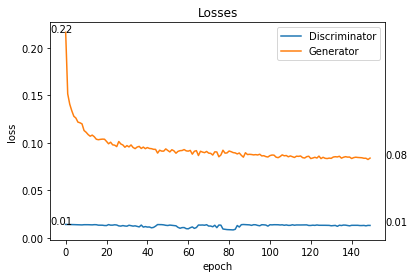

In [44]:
plt.plot(lossD_history,label='Discriminator')
plt.plot(lossG_history, label='Generator')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Losses')
plt.legend()
for var in (lossD_history, lossG_history):
    plt.annotate(f"{var[0]:.2f}", xy=(0, var[0]), xycoords=('axes fraction', 'data'))
    plt.annotate(f"{var[-1]:.2f}", xy=(1, var[-1]), xycoords=('axes fraction', 'data'))

In [ ]:
unloader = transforms.ToPILImage()
test_img = image_loader("sample_img.jpg")
feature_map = Gen_Module(test_img)
output_img = EnD_Module.decoder(feature_map).cpu()
output_img = unloader(output_img.squeeze(0))
test_img = unloader(test_img.squeeze(0).cpu())
fig = plt.figure(figsize=(8,8))
fig.add_subplot(121).set_title('Original Image')
plt.axis('off')
plt.imshow(test_img)
fig.add_subplot(122).set_title('Deblurred Image')
plt.axis('off')
plt.imshow(output_img)

### Save your model

In [17]:
disc_model = '_CGAN_DISC'
gen_model = '_CGAN_GEN'
torch.save(Disc_Module, disc_model)
torch.save(Gen_Module, gen_model)